In [25]:
import scipy.stats as scs
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import seaborn as sns
from statsmodels.stats.weightstats import ztest

In [26]:
#The original source code from the formulas and graphs comes from Nguyen Ngo in his article "The Match Behind A/B Testing with Example Python Code"
#returns a dataframe with fake CTR data
#N_A & N_B size of the two groups
#p_A & p_B converstion rate of control group and experiment group respectively
def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        std (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)


def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_binom_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)


def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")

    
def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    
     # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for individual in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = individual // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df


def abplot(N_A, N_B, p_A, d_hat, sig_level, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, p_A=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        p_A (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = p_A * N_A
    X_B = (p_A + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)
    print("Standard error: "+str(stderr))

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')
        
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    
    print("Confidence Interval from "+str(left)+" to "+str(right) )

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        #p_value = p_val(N_A, N_B, p_A, p_A+d_hat)
        zscore, p_value = ztest(A_group_arr, B_group_arr, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)
        print("P-value: "+str(p_value))
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d - normalized CR')
    plt.ylabel('PDF - nº of subjects ')
    plt.show()


def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    #returns a norm distribution object
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # in other words: from the end of the Conf Int to the end of the experiment distribution
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='purple', alpha=0.25,
                        where=(x > right))
        ax.text(-5 * stderr, null.pdf(0),
                'power (purple)= {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # in other words: from the end of the Conf Int to the end of the control distribution
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha=0.25,
                        where=(x > right))
        ax.text(1.5 * stderr, null.pdf(0),
                'alpha (green) = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper significance boundary
    #in other words: from the beginning of the alternative hyp (exp distribution) to the end of the Conf Int
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='red', alpha=0.25,
                        where=(x < right))
        ax.text(-2 * stderr, null.pdf(0),
                'beta (red) = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha=0.25,
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha=0.25,
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha=0.25,
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()


def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)


def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

In [27]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)


def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE


def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)
    


    return (left, right)


def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z


def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist


def min_sample_size(p_A, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        p_A (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (p_A + p_A+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N


def p_val(N_A, N_B, p_A, p_B):
    """Returns the p-value for an A/B test"""
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [28]:
#What is your practical significance limit ( or minimum detectable effect)? (desired lift), the change in your metric
#whose signficant result would make you apply/launch the experiment 
d_hat = 0.02

#converstion rate of group A
p_A = 0.08  #this will be our baseline mean/proportion
p_B = 0.12
#conversion rate of group B


#What is the size of your test ? being N the number of individuals in your sample
N_A = 1000
N_B = 1000

#Which confidence level =
confidence_level = 0.95
sig_level = 1 - confidence_level

#create random data, being 1 --> user converted and 0 user did not convert
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [29]:
#Summarize data, which is the conversion rate for both groups?
ab_data_summary = ab_data.groupby("group").sum()

ab_data_summary["total"] = ab_data.groupby("group").count()["converted"]

ab_data_summary["CR"]= ab_data_summary["converted"]/ab_data_summary["total"]

display(ab_data_summary)

#remember this "scs.binom.pmf(k=2, n=10, p=0.5)" is read as:
#probability of 2 heads after 10 throws with a probability of head = 0.5

#remember this "binom.cdf(k=5, n=10, p=0.5)" is read as:
#probability of 5 heads or less after 10 throws with a probability of head = 0.5


#extract data from dataframe
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()

N_A, N_B = len(A_group), len(B_group)


p_A, p_B = A_converted / N_A, B_converted / N_B

A_group_arr = np.asarray(A_group["converted"].to_list())
B_group_arr = np.asarray(B_group["converted"].to_list())

,converted,total,CR
group,,,
A,76,993,0.076536
B,114,1007,0.113208


Text(0, 0.5, 'probability')

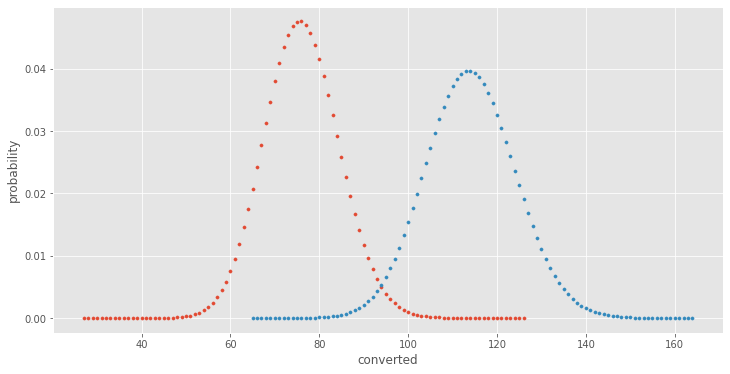

In [30]:
#Plot the test and control group's probability mass functions

fig, ax = plt.subplots(figsize=(12,6))
#np.linspace(1,4,4) returns a np array from 1 until 4 divided into 4. --> 1,2,3,4
xA = np.linspace(A_converted-49, A_converted+50, 100)
#Return a numpy array of the probabilities given a sample size of N_A
#and a probability of p_A, for a range of values xA
#example: what is the probability of "1" given a probaility p_A and the total of N_A ?
yA = scs.binom(N_A, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(N_B, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('converted')
plt.ylabel('probability')

This graph helps us to see the probability mass distribution of our data. 
For example when tthe two curves touch each other, it means the progability for both groups is exactly the same

But we cannot extract any conclusions with this graph

Since we have different sample sizes we will have to normalize the data in order to compare the two groups. 
We can use the normal only if the sample size is large. Since the binomial distribution approximates a normal when "n" is large
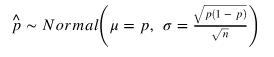

In this case, since we do not know the standard deviation of the population, we use the standard deviation of the sample divided by the square root of n as an estimation

In [31]:
# Calculation of the standard error of the mean
#the fomula comprises the standard deviation of the sample divided by the sqrt(n)
#remember, since the population standard deviation is rarely known, we use the standard deviation
#of the sample to estimate the standard error of the mean
SE_A = scs.bernoulli.std(p_A) / np.sqrt(N_A)
SE_B = scs.bernoulli.std(p_B) / np.sqrt(N_B)

Text(0, 0.5, 'PDF')

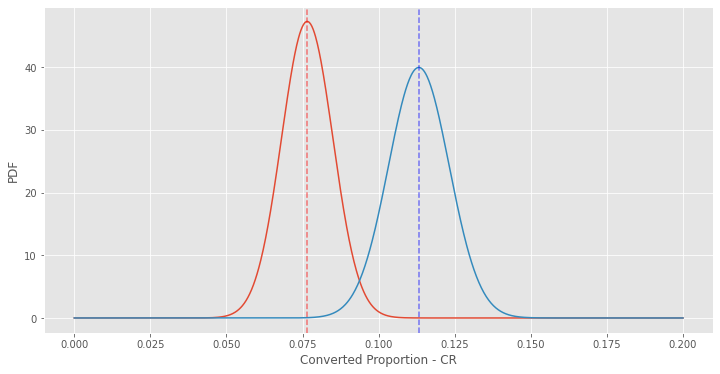

In [32]:


fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion - CR')
plt.ylabel('PDF')

The distance between the two vertical lines (which represent the CR, in other words the p), is the mean difference between the control and test groups

In the y-axis we can s

## Hypothesis Testing

Now we wanto test if there is any significant differerence between the two probabilities. 
For that we want to plot the distribution of the mean difference.

The standard deviation will be pooled, using the two groups
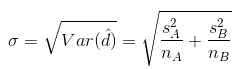





In other words:
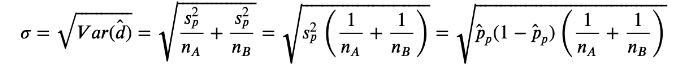

s --> standard deviation of of the sample of the Bernoulli distribution

H0 --> the means are the same  p_A - p_B = 0
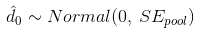

H1 --> the means are different p_A - p_B != 0

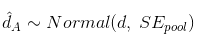
We will assume we can use a normal distribution for that


In [33]:
#Calculate Z-score and P-value
zscore, p_value = ztest(A_group_arr, B_group_arr, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)
if p_value < sig_level/2:
    print("We reject the H0")
else:
    print("We cannot reject the H0")

We reject the H0


Standard error: 0.013113291957509076
Confidence Interval from -0.025701579955476533 to 0.025701579955476533
P-value: 0.0051004748503799165


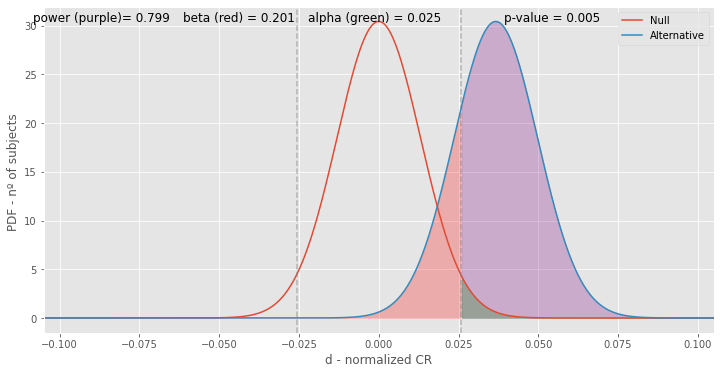

In [34]:
abplot(N_A, N_B, p_A, p_B-p_A, sig_level, show_power=True,
           show_alpha=True, show_beta=True, show_p_value=True,
           show_legend=True)

## How to calculate sample size

In order to find the sample size for each group so that we find that the difference in means/proportions of control/experiment is significantly equal or greater than the minimum detectable effect we will use this formula:

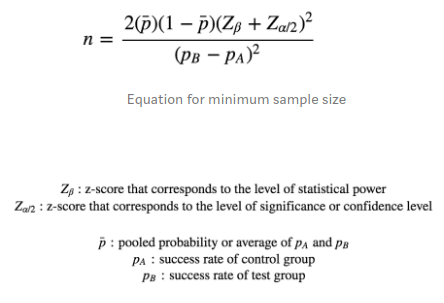

In [35]:
#The size calculation will depend on the baseline mean/proportion, in our case p_A
# in the minimum detectable effect (d_hat), the power and alpha
n = min_sample_size(p_A, d_hat, power=0.8, sig_level=0.05)

print("If we want to test that there is a significance difference of at least "+ str(mde)+ 
      " between control an experiment means/proportions"+ " we need a sample size of "+ str(n))

If we want to test that there is a significance difference of at least 0.02 between control an experiment means/proportions we need a sample size of 3102.1643116156188
